In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from itertools import combinations
from tqdm import tqdm


In [2]:
PROJECT_ROOT = Path.cwd().parents[0]
DATA_DIR = PROJECT_ROOT / "data" / "processed"

train_edges = pd.read_csv(DATA_DIR / "train_edges.csv")
test_edges  = pd.read_csv(DATA_DIR / "test_edges.csv")
core_nodes  = set(map(int, (DATA_DIR / "core_nodes.txt").read_text().splitlines()))

print("Train edges:", len(train_edges))
print("Test edges (core-filtered):", len(test_edges))
print("Core nodes:", len(core_nodes))


Train edges: 20778
Test edges (core-filtered): 3867
Core nodes: 3942


In [3]:
G = nx.Graph()
G.add_edges_from(train_edges[["u", "v"]].itertuples(index=False, name=None))

# restrict to core subgraph
G_core = G.subgraph(core_nodes).copy()

print("G_core nodes:", G_core.number_of_nodes())
print("G_core edges:", G_core.number_of_edges())


G_core nodes: 3942
G_core edges: 10670


In [4]:
E_train = set(tuple(sorted(e)) for e in G_core.edges())
E_test  = set(tuple(sorted(e)) for e in test_edges[["u","v"]].itertuples(index=False, name=None))
print("Train edges in core:", len(E_train))
print("Test edges:", len(E_test))


Train edges in core: 10670
Test edges: 3867


In [5]:
def generate_2hop_candidates(G, max_candidates=1_500_000, seed=42):
    """
    Generate candidate non-edges that are within 2 hops:
    for each node u, consider pairs (u, v) where v is in neighbors-of-neighbors.
    """
    rng = np.random.default_rng(seed)
    cand = set()

    nodes = list(G.nodes())
    rng.shuffle(nodes)

    for u in tqdm(nodes, desc="Generating 2-hop candidates"):
        neigh_u = set(G.neighbors(u))
        two_hop = set()
        for w in neigh_u:
            two_hop.update(G.neighbors(w))
        two_hop.discard(u)
        # remove 1-hop neighbors (we only want non-edges)
        two_hop -= neigh_u

        for v in two_hop:
            a, b = (u, v) if u < v else (v, u)
            if (a, b) not in cand:
                cand.add((a, b))
                if len(cand) >= max_candidates:
                    return cand
    return cand

candidates = generate_2hop_candidates(G_core, max_candidates=800_000)  # safe on laptop
print("Raw candidates:", len(candidates))


Generating 2-hop candidates: 100%|██████████| 3942/3942 [00:00<00:00, 16322.71it/s]

Raw candidates: 63841


In [6]:
candidates = [e for e in candidates if e not in E_train]
print("Candidates after removing train edges:", len(candidates))


Candidates after removing train edges: 63841


In [7]:
deg = dict(G_core.degree())

def common_neighbors(u, v):
    return len(list(nx.common_neighbors(G_core, u, v)))

def jaccard(u, v):
    Nu = set(G_core.neighbors(u))
    Nv = set(G_core.neighbors(v))
    inter = len(Nu & Nv)
    union = len(Nu | Nv)
    return inter / union if union > 0 else 0.0

def adamic_adar(u, v):
    s = 0.0
    for z in nx.common_neighbors(G_core, u, v):
        kz = deg.get(z, 0)
        if kz > 1:
            s += 1.0 / np.log(kz)
    return s

def pref_attach(u, v):
    return deg.get(u, 0) * deg.get(v, 0)


In [8]:
rows = []
for (u, v) in tqdm(candidates, desc="Scoring candidates"):
    rows.append((u, v,
                 common_neighbors(u, v),
                 jaccard(u, v),
                 adamic_adar(u, v),
                 pref_attach(u, v)))

scores = pd.DataFrame(rows, columns=["u","v","CN","Jaccard","AA","PA"])
scores.head()


Scoring candidates: 100%|██████████| 63841/63841 [00:02<00:00, 24618.16it/s]


,u,v,CN,Jaccard,AA,PA
0,14103,39176,1,0.111111,0.455120,16
1,14975,45521,1,0.090909,0.296974,32
2,16619,26304,1,0.043478,0.360674,144
3,42304,50878,1,0.071429,0.389871,56
4,12561,35480,1,0.055556,0.306928,90


In [9]:
n_new = len(E_test)
core_size = G_core.number_of_nodes()
m_old = len(E_train)

random_prob = n_new / ( (core_size*(core_size-1)//2) - m_old )
print("Random predictor correctness probability:", random_prob)


Random predictor correctness probability: 0.000498514833168988


In [10]:
def topn_accuracy(scores_df, score_col, E_test, n_new):
    df = scores_df.sort_values(score_col, ascending=False)
    top = list(zip(df["u"].values[:n_new], df["v"].values[:n_new]))
    correct = sum(1 for e in top if (min(e), max(e)) in E_test)
    return correct / n_new, correct

results = []
for col in ["CN","Jaccard","AA","PA"]:
    acc, correct = topn_accuracy(scores, col, E_test, n_new)
    results.append((col, acc, correct))

res_df = pd.DataFrame(results, columns=["Method","Top-n accuracy","Correct in top-n"])
res_df["Improvement_vs_Random"] = res_df["Top-n accuracy"] / random_prob
res_df.sort_values("Top-n accuracy", ascending=False)


,Method,Top-n accuracy,Correct in top-n,Improvement_vs_Random
2,AA,0.357642,1383,717.414125
1,Jaccard,0.293768,1136,589.285933
0,CN,0.267391,1034,536.374696
3,PA,0.061029,236,122.422078


In [12]:
cand_set = set((min(u,v), max(u,v)) for u,v in zip(scores["u"], scores["v"]))
coverage = sum(1 for e in E_test if e in cand_set) / len(E_test)
print("Test-edge coverage inside candidate set:", coverage)


Test-edge coverage inside candidate set: 0.7341608482027412


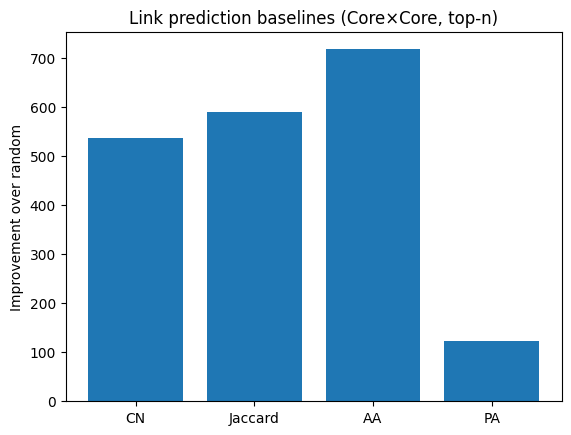

In [11]:
plt.figure()
plt.bar(res_df["Method"], res_df["Improvement_vs_Random"])
plt.ylabel("Improvement over random")
plt.title("Link prediction baselines (Core×Core, top-n)")
plt.show()


In [13]:
# Fast neighbor dict for repeated use
neighbors = {u: set(G_core.neighbors(u)) for u in G_core.nodes()}
nodes_core = list(G_core.nodes())

# Candidate list as tuples (already exists, but let's ensure format)
cand_list = [(int(u), int(v)) for u, v in zip(scores["u"], scores["v"])]

print("Candidates for Katz/PPR:", len(cand_list))
print("Core nodes:", G_core.number_of_nodes(), "Core edges:", G_core.number_of_edges())

Candidates for Katz/PPR: 63841
Core nodes: 3942 Core edges: 10670


In [14]:
def katz_truncated_scores(G, candidates, beta=0.05, max_len=3):
    """
    Truncated Katz score for non-edge candidates.
    Uses path counts of length 2 and 3 only (fast on CPU).
    score(u,v) = beta^2 * (#length-2 paths) + beta^3 * (#length-3 paths)
    """
    nbrs = {u: set(G.neighbors(u)) for u in G.nodes()}
    scores_katz = []

    for (u, v) in tqdm(candidates, desc=f"Katz truncated (beta={beta}, L={max_len})"):
        Nu = nbrs[u]
        Nv = nbrs[v]

        # length-2 paths = common neighbors
        p2 = len(Nu & Nv)
        score = (beta ** 2) * p2

        if max_len >= 3:
            # Count length-3 walks approximately/exactly via common-neighbor expansion
            # number of 3-step walks from u to v = sum_{x in N(u)} |N(x) ∩ N(v)|
            p3 = 0
            for x in Nu:
                p3 += len(nbrs[x] & Nv)
            score += (beta ** 3) * p3

        scores_katz.append(score)

    return np.array(scores_katz, dtype=float)

In [15]:
scores["Katz_t3_b005"] = katz_truncated_scores(G_core, cand_list, beta=0.05, max_len=3)
scores["Katz_t3_b010"] = katz_truncated_scores(G_core, cand_list, beta=0.10, max_len=3)

scores[["Katz_t3_b005", "Katz_t3_b010"]].describe()

Katz truncated (beta=0.1, L=3): 100%|██████████| 63841/63841 [00:00<00:00, 67923.84it/s]


,Katz_t3_b005,Katz_t3_b010
count,63841.000000,63841.000000
mean,0.003942,0.019064
std,0.005093,0.030455
min,0.002500,0.010000
25%,0.002750,0.012000
50%,0.003000,0.014000
75%,0.003500,0.018000
max,0.124750,0.768000


In [16]:
from collections import defaultdict

# Group candidates by source u
cand_by_u = defaultdict(list)
for idx, (u, v) in enumerate(cand_list):
    cand_by_u[u].append((idx, v))

print("Unique source nodes in candidates:", len(cand_by_u))

Unique source nodes in candidates: 3304


In [17]:
def ppr_scores_for_candidates(G, cand_by_u, alpha=0.15):
    """
    Personalized PageRank with restart to source u.
    In NetworkX, alpha is the damping/restart parameter for pagerank personalization.
    (Equivalent to random surfer teleport probability.)
    """
    ppr_scores = np.zeros(len(cand_list), dtype=float)

    for u, items in tqdm(cand_by_u.items(), desc=f"PPR per source (alpha={alpha})"):
        personalization = {n: 0.0 for n in G.nodes()}
        personalization[u] = 1.0

        # Compute PPR vector rooted at u
        ppr_u = nx.pagerank(G, alpha=1-alpha, personalization=personalization, max_iter=100, tol=1e-6)
        # Note: nx.pagerank uses alpha = probability of following link.
        # Our input alpha here is restart prob, so we pass (1 - alpha).

        for idx, v in items:
            ppr_scores[idx] = ppr_u.get(v, 0.0)

    return ppr_scores

In [18]:
scores["PPR_r015"] = ppr_scores_for_candidates(G_core, cand_by_u, alpha=0.15)  # restart 0.15
scores["PPR_r030"] = ppr_scores_for_candidates(G_core, cand_by_u, alpha=0.30)  # stronger restart

scores[["PPR_r015", "PPR_r030"]].describe()

PPR per source (alpha=0.3): 100%|██████████| 3304/3304 [03:51<00:00, 14.28it/s]


,PPR_r015,PPR_r030
count,63841.000000,63841.000000
mean,0.005411,0.005047
std,0.009760,0.008500
min,0.000190,0.000178
25%,0.001453,0.001297
50%,0.002702,0.002527
75%,0.005528,0.005308
max,0.235569,0.162935


In [19]:
# If not already in memory
n_new = len(E_test)
core_size = G_core.number_of_nodes()
m_old = len(E_train)
random_prob = n_new / ((core_size * (core_size - 1) // 2) - m_old)

method_cols = ["CN", "Jaccard", "AA", "PA", "Katz_t3_b005", "Katz_t3_b010", "PPR_r015", "PPR_r030"]

results_all = []
for col in method_cols:
    acc, correct = topn_accuracy(scores, col, E_test, n_new)
    results_all.append((col, acc, correct))

res_all_df = pd.DataFrame(results_all, columns=["Method", "Top-n accuracy", "Correct in top-n"])
res_all_df["Improvement_vs_Random"] = res_all_df["Top-n accuracy"] / random_prob
res_all_df["Normalized_over_Coverage"] = res_all_df["Top-n accuracy"] / coverage
res_all_df = res_all_df.sort_values("Top-n accuracy", ascending=False)

res_all_df

,Method,Top-n accuracy,Correct in top-n,Improvement_vs_Random,Normalized_over_Coverage
2,AA,0.357642,1383,717.414125,0.487143
1,Jaccard,0.293768,1136,589.285933,0.400141
0,CN,0.267391,1034,536.374696,0.364213
6,PPR_r015,0.266615,1031,534.818483,0.363156
7,PPR_r030,0.252909,978,507.325390,0.344487
4,Katz_t3_b005,0.246703,954,494.875687,0.336034
5,Katz_t3_b010,0.226274,875,453.895415,0.308207
3,PA,0.061029,236,122.422078,0.083128


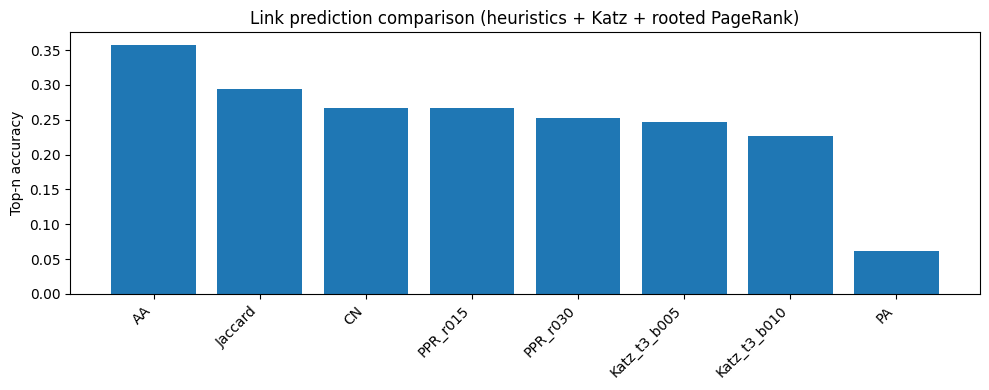

In [20]:
plt.figure(figsize=(10,4))
plt.bar(res_all_df["Method"], res_all_df["Top-n accuracy"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Top-n accuracy")
plt.title("Link prediction comparison (heuristics + Katz + rooted PageRank)")
plt.tight_layout()
plt.show()

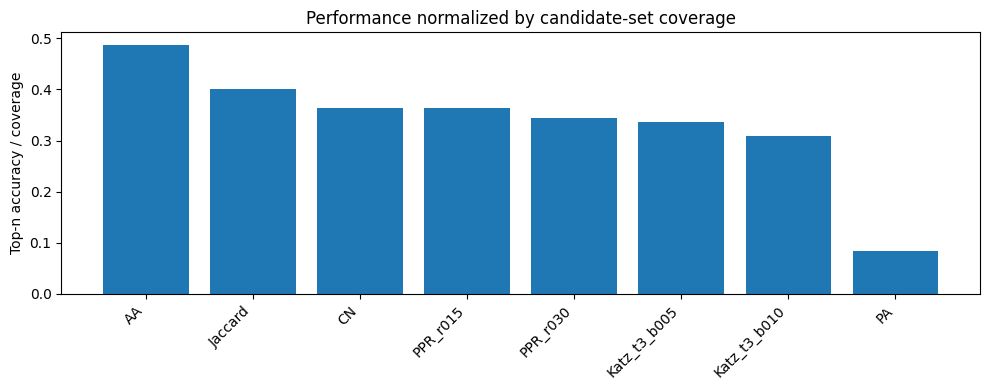

In [21]:
plt.figure(figsize=(10,4))
plt.bar(res_all_df["Method"], res_all_df["Normalized_over_Coverage"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Top-n accuracy / coverage")
plt.title("Performance normalized by candidate-set coverage")
plt.tight_layout()
plt.show()